## Mitigating vanishing/exploding gradient problem in FF networks
* ### BatchNorm
* ### Proper initialization

In [ ]:
import tensorflow as tf
import tensorflow.keras as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
tf.config.list_physical_devices('GPU')

## Fashon MNIST classification dataset

In [2]:
fashion_mnist=tf.keras.datasets.fashion_mnist.load_data()

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist

In [4]:
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

In [5]:
X_train.shape

(55000, 28, 28)

In [6]:
X_train.dtype

dtype('uint8')

In [7]:
# Data normalization
X_train, X_valid, X_test = X_train/255., X_valid/255., X_test/255. 

In [8]:
X_train.dtype

dtype('float64')

In [9]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [10]:
tf.random.set_seed(42)

## Model definition

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation='softmax')
])

### Below we see that BN leayer has parmeters corresponding to four times the input vector size
### e.g. 3136 == 4 * 784

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 batch_normalization_2 (Batc  (None, 100)              4

### Not all variables in BN are trainable by SGD - 
### moving averages for the final $\mu$, $\sigma$ are not trainable

In [15]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

## Model definition

### In order to place BN before activations we need to introduce an explicit activaiton layers into the model

### We also remove bias, because BN contains a free term, which in this case will serve as a trainable bias

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, kernel_initializer='he_normal', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(100, kernel_initializer='he_normal', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [14]:
model.compile(loss=K.losses.sparse_categorical_crossentropy,
             optimizer=K.optimizers.SGD(),
             metrics=[K.metrics.sparse_categorical_accuracy])

## Training

In [15]:
history = model.fit(X_train, y_train, 
         epochs=30,
         validation_data=[X_valid, y_valid])

Epoch 1/30


2023-06-28 19:19:37.230138: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1719/1719 [==============================] - 4s 2ms/step - loss: 0.6098 - sparse_categorical_accuracy: 0.7971 - val_loss: 0.4333 - val_sparse_categorical_accuracy: 0.8474
Epoch 2/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4253 - sparse_categorical_accuracy: 0.8514 - val_loss: 0.3755 - val_sparse_categorical_accuracy: 0.8606
Epoch 3/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3799 - sparse_categorical_accuracy: 0.8652 - val_loss: 0.3544 - val_sparse_categorical_accuracy: 0.8764
Epoch 4/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3491 - sparse_categorical_accuracy: 0.8763 - val_loss: 0.3435 - val_sparse_categorical_accuracy: 0.8770
Epoch 5/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3282 - sparse_categorical_accuracy: 0.8837 - val_loss: 0.3341 - val_sparse_categorical_accuracy: 0.8722
Epoch 6/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3085 - sparse_categoric

In [44]:
history.params['epochs']


30

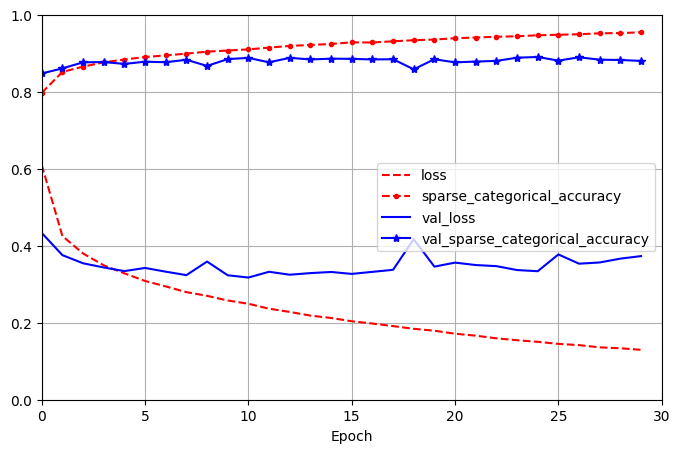

In [16]:
pd.DataFrame(history.history).plot(figsize=(8, 5),
                                  xlim=[0, history.params['epochs']],
                                  ylim=[0, 1],
                                  grid=True,
                                  xlabel='Epoch',
                                  style=["r--", "r--.", "b-", "b-*"])
plt.show()

## Model evaluation

In [17]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.3797 - sparse_categorical_accuracy: 0.8811


[0.37972182035446167, 0.8810999989509583]

In [46]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 847us/step - loss: 0.3209 - sparse_categorical_accuracy: 0.8879


[0.32093656063079834, 0.8878999948501587]

In [47]:
X_new=X_test[:3]

In [50]:
y_proba=model.predict(X_new)

1/1 [==============================] - 0s 59ms/step
